### Homework 4

#### Instructions:

Use the Titanic dataset to experiment with the different evaluation methods we have looked at:

- PrecisionRecallDisplay
- RocCurveDisplay
- Learning_curve
- Validation_curve (for at least 3 parameters)

For each, read the documentation, compute the graphs and give your analysis / explanation

- Do a qualitative error analysis (look at the false positives and negatives and come up with patterns / explanations)



## 1. Experiment

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn 
print(sklearn.__version__)

1.2.2


In [5]:
titanic = pd.read_csv("data/titanic.csv")

In [6]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
titanic.drop(columns= ['Cabin'], inplace=True) # we will drop the Cabin column

In [8]:
titanic.dropna(subset=['Embarked'], inplace=True) # we will drop rows with missing Embarked

In [9]:
# Define our X and y
y = titanic.Survived
X = titanic.drop(columns=['Survived']) 

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, shuffle=True, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((711, 10), (178, 10), (711,), (178,))

In [11]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [12]:
ohe = OneHotEncoder()
imputer = KNNImputer() 
scaler = StandardScaler() 
logreg = LogisticRegression(random_state=42) 

# Numeric features will be imputed and then scaled
numeric_preprocessing = make_pipeline (imputer, scaler)

# Categorical features will be encoded numerically
categorical_preprocessing = make_pipeline (ohe)

preprocessor = make_column_transformer(
    (numeric_preprocessing, ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']),
    (categorical_preprocessing, ['Sex', 'Embarked']),
    remainder='drop')

pipe = make_pipeline (preprocessor, logreg)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'Pclass']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Embarked'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

In [13]:
param_grid = [{
    'columntransformer__pipeline-1__knnimputer__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9], 
    'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}]

In [14]:
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=1, refit=True)
gs.fit(X_train, y_train) 

Fitting 10 folds for each of 63 candidates, totalling 630 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'Pclass']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'columntransformer__pipeline-1__knnimputer__n_neighbors': [1,
                                                                                     2,
                                                                                     3,
                                                                                     4,
                                                                                     5,
                                                                                     6,
                                                                                     7,
                                                                                     8,
                                                                                     9],
                          'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10,
                                                    100, 1000]}],
             scoring='f1_macro', verbose=1)

In [15]:
gs.best_score_ # best score obtained (on cross-validation on train data!)

0.7917218114331039

In [16]:
gs.best_params_

{'columntransformer__pipeline-1__knnimputer__n_neighbors': 3,
 'logisticregression__C': 1.0}

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       109
           1       0.70      0.78      0.74        69

    accuracy                           0.79       178
   macro avg       0.78      0.79      0.78       178
weighted avg       0.79      0.79      0.79       178



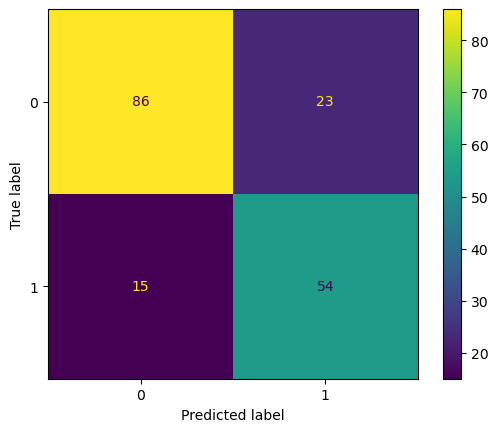

In [17]:
y_test_predictions = gs.predict(X_test)
print(classification_report(y_test, y_test_predictions))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predictions)

## 2. Qualitative Analysis

In [19]:
# Make a dataframe with the true classes and the predicted classes and the passengerid
d = {'true': y_test, 'pred': y_test_predictions, 'id': X_test.PassengerId}
output = pd.DataFrame(data=d)

In [20]:
output.sample(3)

,true,pred,id
618,1,1,619
466,0,0,467
175,0,0,176


In [21]:
print('False negatives:')
fn = output[(output['true'] == 1) & (output['pred'] == 0)].index
fn
# the gold standard says 'high income' and the model says 'low income'

False negatives:


Index([804, 447, 68, 821, 559, 744, 869, 570, 553, 193, 248, 267, 579, 25, 85], dtype='int64')

In [22]:
titanic.loc[fn]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
804,805,1,3,"Hedman, Mr. Oskar Arvid",male,27.0,0,0,347089,6.9750,S
447,448,1,1,"Seward, Mr. Frederic Kimber",male,34.0,0,0,113794,26.5500,S
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,S
821,822,1,3,"Lulic, Mr. Nikola",male,27.0,0,0,315098,8.6625,S
559,560,1,3,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",female,36.0,1,0,345572,17.4000,S
744,745,1,3,"Stranden, Mr. Juho",male,31.0,0,0,STON/O 2. 3101288,7.9250,S
869,870,1,3,"Johnson, Master. Harold Theodor",male,4.0,1,1,347742,11.1333,S
570,571,1,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,S
553,554,1,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.2250,C
193,194,1,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0000,S


In [23]:
print('False positives:')
fp = output[(output['true'] == 0) & (output['pred'] == 1)].index
fp

False positives:


Index([295,  30, 602, 583, 729, 312, 362, 423, 297, 140, 205, 782, 474, 111,
        64, 501,  49, 885, 498,  83, 199, 852, 807],
      dtype='int64')

In [24]:
titanic.loc[fp]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
295,296,0,1,"Lewy, Mr. Ervin G",male,NaN,0,0,PC 17612,27.7208,C
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,C
602,603,0,1,"Harrington, Mr. Charles H",male,NaN,0,0,113796,42.4000,S
583,584,0,1,"Ross, Mr. John Hugo",male,36.0,0,0,13049,40.1250,C
729,730,0,3,"Ilmakangas, Miss. Pieta Sofia",female,25.0,1,0,STON/O2. 3101271,7.9250,S
312,313,0,2,"Lahtinen, Mrs. William (Anna Sylfven)",female,26.0,1,1,250651,26.0000,S
362,363,0,3,"Barbara, Mrs. (Catherine David)",female,45.0,0,1,2691,14.4542,C
423,424,0,3,"Danbom, Mrs. Ernst Gilbert (Anna Sigrid Maria ...",female,28.0,1,1,347080,14.4000,S
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,S
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,C


Now that we have access to all the false positives and negatives (i.e. all errors made by the trained algorithm), we can see whether we can find any patterns or structure in the errors. This can be done by **eyeballing** the errors, but also by seeing whether for specific features the distribution of errors matches or doesn't match the a priori distribution of the values of that feature.

In [26]:
titanic.Pclass.value_counts(normalize=True)

Pclass
3    0.552306
1    0.240720
2    0.206974
Name: proportion, dtype: float64

In [27]:
titanic.loc[fn].Pclass.value_counts(normalize=True)

Pclass
3    0.733333
1    0.133333
2    0.133333
Name: proportion, dtype: float64

In [28]:
titanic.loc[fp].Pclass.value_counts(normalize=True)

Pclass
3    0.521739
1    0.391304
2    0.086957
Name: proportion, dtype: float64

Passengers in third class are more othen erroneously categorized as not having survived (false negative). On the other hand, passengers in first class are overgeneralized as surviving (false positive). This is to be expected as Pclass strongly predicts survival leading to overgeneralization. 

In [30]:
titanic.Embarked.value_counts(normalize=True)

Embarked
S    0.724409
C    0.188976
Q    0.086614
Name: proportion, dtype: float64

In [31]:
titanic.loc[fp].Embarked.value_counts(normalize=True)

Embarked
S    0.565217
C    0.347826
Q    0.086957
Name: proportion, dtype: float64

In [32]:
titanic.loc[fn].Embarked.value_counts(normalize=True)

Embarked
S    0.933333
C    0.066667
Name: proportion, dtype: float64

The model seems to have a strange and erroneous bias toward predicting that passengers embarking in Southampton did not survive.

## 3. Learning curves and parameter analysis

In [35]:
from sklearn.model_selection import learning_curve, validation_curve

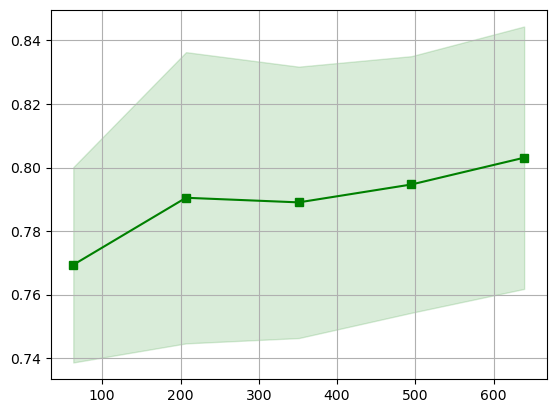

In [36]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe, X=X_train, y=y_train, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, test_mean, color='green', marker='s')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()

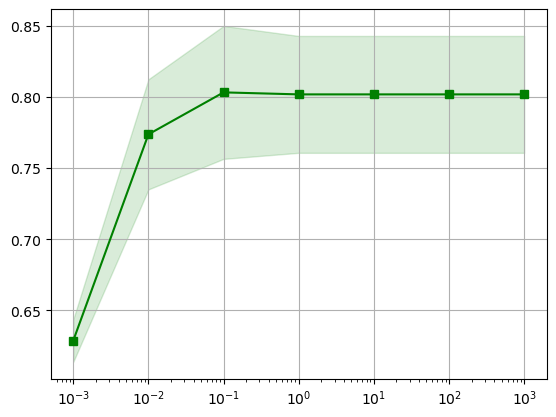

In [37]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
train_scores, test_scores = validation_curve(estimator=pipe, X=X_train, y=y_train, \
                                             param_name= 'logisticregression__C', param_range=param_range, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, test_mean, color='green', marker='s')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.show()

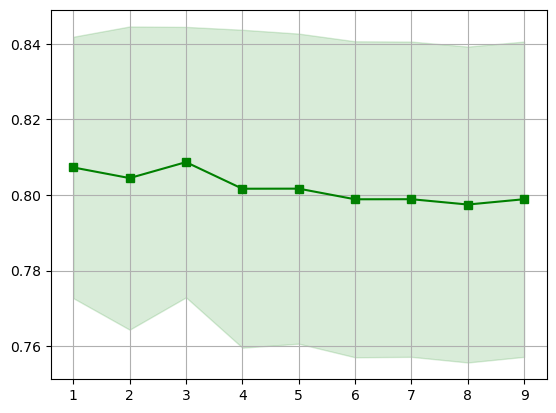

In [38]:
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9]
train_scores, test_scores = validation_curve(
    estimator=pipe, X=X_train, y=y_train, 
    param_name= 'columntransformer__pipeline-1__knnimputer__n_neighbors', 
    param_range=param_range, 
    cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, test_mean, color='green', marker='s')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.show()

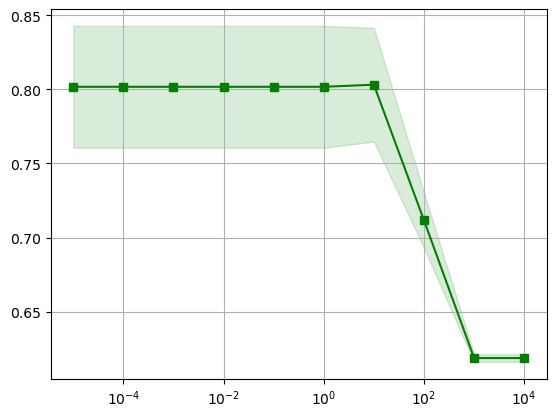

In [39]:
param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
train_scores, test_scores = validation_curve(estimator=pipe, X=X_train, y=y_train, \
                                             param_name= 'logisticregression__tol', param_range=param_range, cv=10)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, test_mean, color='green', marker='s')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.show()

# tolerance: how much change in the cost function is considered irrelevant: when should the optimization stop iterating

## 4. PrecisionRecallDisplay and RocCurveDisplay

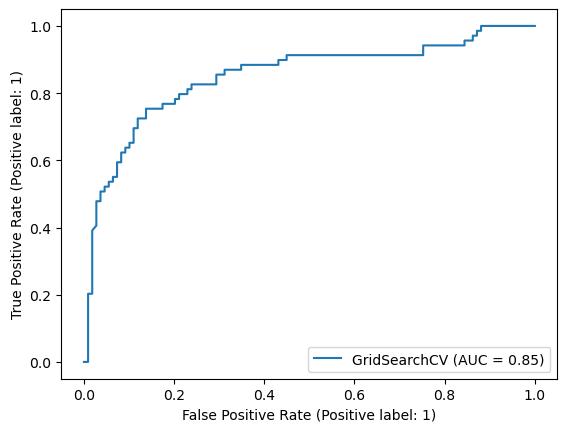

In [41]:
from sklearn.metrics import RocCurveDisplay
# Area under the curve 
RocCurveDisplay.from_estimator(gs, X_test, y_test)

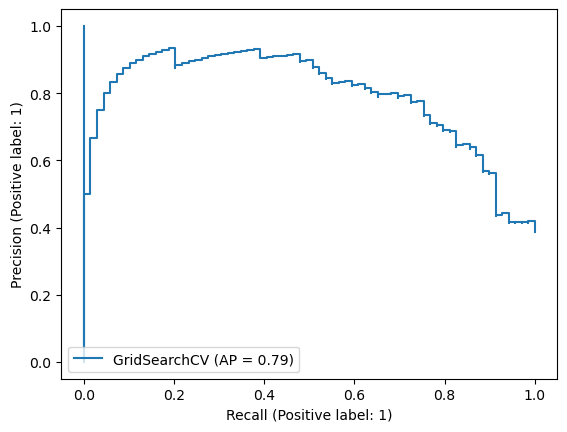

In [42]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
# Precision - Recall curve

PrecisionRecallDisplay.from_estimator(gs, X_test, y_test)